In [24]:
%pip install pandas scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv("cleaned_early_pd_dataset.csv")

In [27]:
cols_to_drop = ['patient_id', 'visit_id', 'visit_month'] + [col for col in df.columns if col.endswith('_was_imputed')]
df_cleaned = df.drop(columns=cols_to_drop)

In [28]:
X = df_cleaned.drop(columns=['label'])
y = df_cleaned['label']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [32]:
best_svm = grid_search.best_estimator_

In [33]:
y_pred = best_svm.predict(X_test_scaled)
y_proba = best_svm.predict_proba(X_test_scaled)[:, 1]

In [34]:
print("Best Hyperparameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        75
           1       0.93      0.92      0.93       139

    accuracy                           0.91       214
   macro avg       0.90      0.90      0.90       214
weighted avg       0.91      0.91      0.91       214



In [35]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.3f}")

ROC-AUC Score: 0.971


In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No PD', 'PD'],)

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

Text(0.5, 1.0, 'Confusion Matrix')

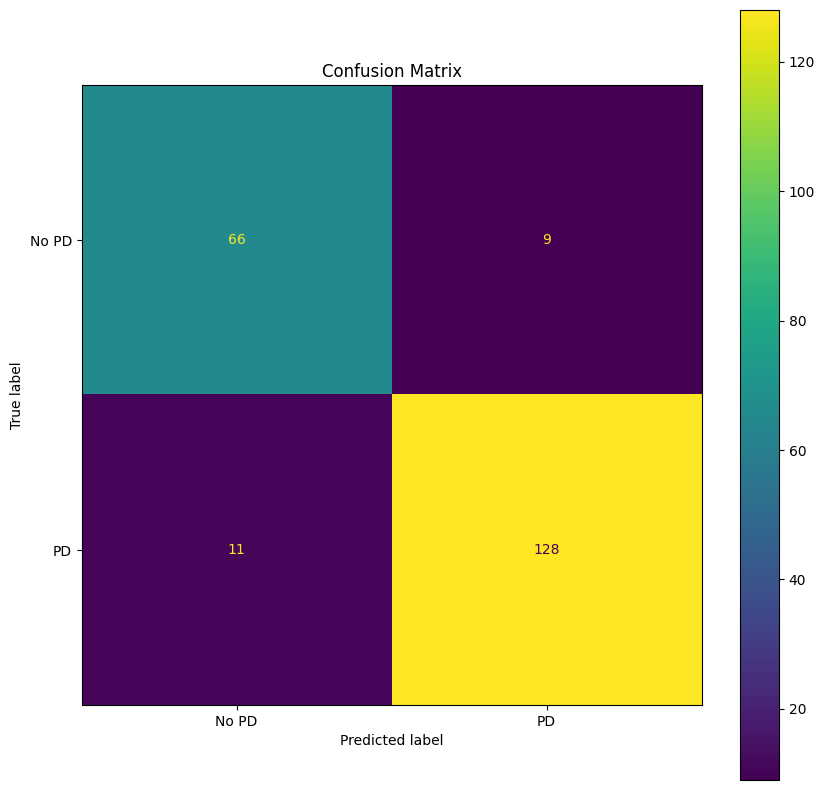

In [38]:
plt.figure(figsize=(10, 10))
disp.plot(cmap='viridis', ax=plt.gca())
plt.title("Confusion Matrix")

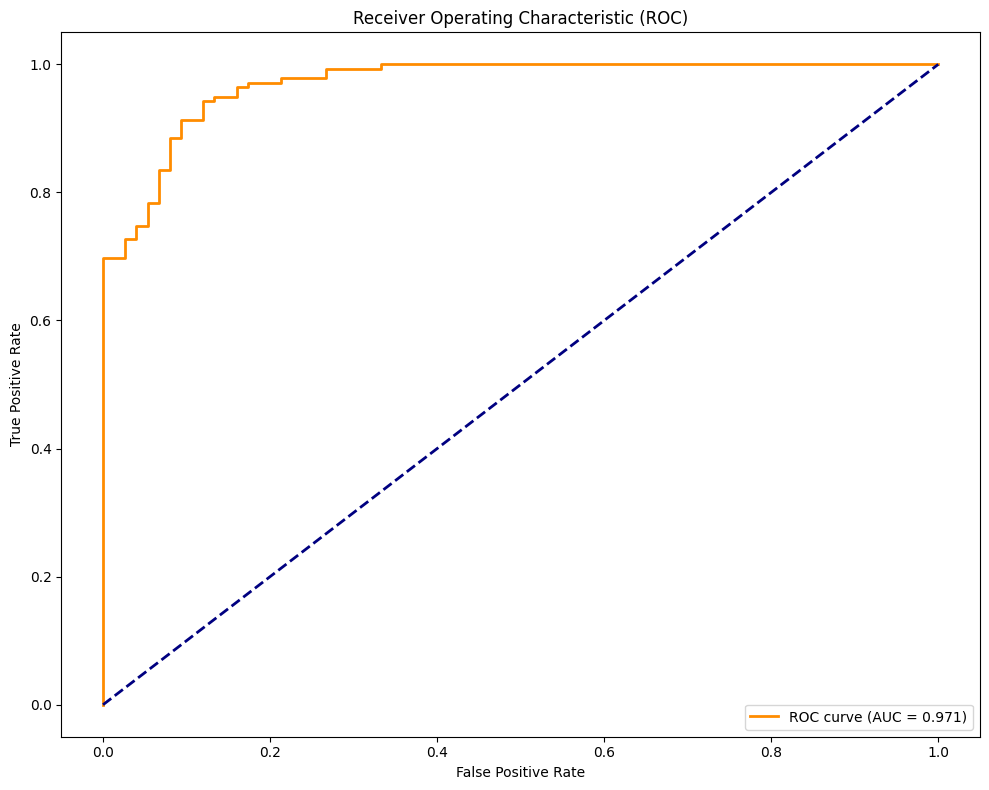

In [39]:
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()